In [1]:
# imports and functions, does nothing

from IPython.display import Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from json import JSONEncoder
import json

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def serialize(uri, o, version=''):
    try:
        os.remove(".cache/"+uri)
    except:
        pass
    with open(".cache/"+uri, "w") as f:
        if version != '':
            f.write('#version: '+version+'\n')
        json.dump(o, f, cls=NumpyArrayEncoder)

def deserialize(uri, version=''):
    if os.path.isfile(".cache/"+uri):
        with open(".cache/"+uri, "r") as f:
            data = []
            for line in f:
                if not line.startswith('#version:'):
                    data.append(line)
            return json.loads(''.join(data))
    return None

def load_or_compute(uri, compute_function, rebuild=False):
    data = None
    if not rebuild:
        data = deserialize(uri)
    if data is None:
        data = compute_function()
        serialize(uri, data)
        return data
    return data

def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""

In [2]:
data_all = np.load('datasets/quic-100p-150-40runs.npy', allow_pickle=True).item()
data = data_all['nofilter'] # adblock + decentraleyes
urls = [url for url in data]

# total incoming size
def add(a, b):
    x = 0
    if a is not None:
        x += abs(a)
    if b is not None:
        x += abs(b)
    return x

def toOldHARFormat(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = request
                data2[url][sample].append([t, add(out_h, out_b), add(inc_h, inc_b)])
    return data2

data_old_format = toOldHARFormat(data)
data_old_format_noprotections = toOldHARFormat(data_all['nofilter'])

In [3]:
from lib.features import *
from lib.rf import *

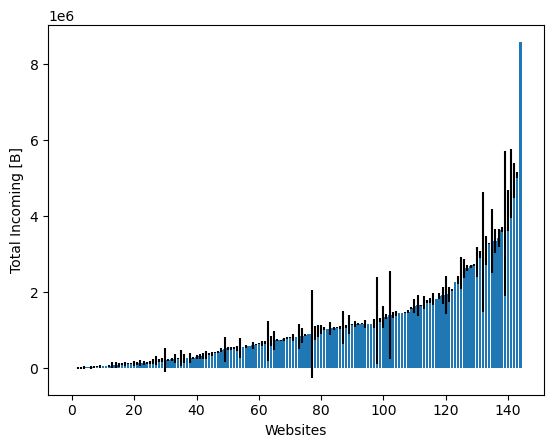

In [4]:
# total incoming size
def add(a, b):
    x = 0
    if a is not None:
        x += abs(a)
    if b is not None:
        x += abs(b)
    return x

def incoming_sizes_distrib(data):
    incoming_bytes = []
    incoming_bytes_per_website = dict()

    for url in data:
        incoming_bytes_for_this_website = []
        for sample in data[url]:
            total = 0
            for request in data[url][sample]:
                domain, fullurl, t_query, out_h, out_b, t_resp, inc_h, inc_b = request
                total += add(inc_h, inc_b)
            incoming_bytes_for_this_website.append(total)

        if len(incoming_bytes_for_this_website) > 0:
            incoming_bytes_per_website[url] =  [np.mean(incoming_bytes_for_this_website), np.std(incoming_bytes_for_this_website)]

    tuples = list(incoming_bytes_per_website.items())
    tuples.sort(key=lambda row: row[1][0])


    xs = [t[0][:3] for t in tuples]
    ys = [int(t[1][0]) for t in tuples]
    yerr = [int(t[1][1]) for t in tuples]

    plt.bar(np.arange(len(ys)), ys, yerr=yerr)
    plt.xlabel('Websites')
    plt.ylabel('Total Incoming [B]')
    #plt.yscale('log')
    #plt.ylim([0, 10000])

incoming_sizes_distrib(data)

In [5]:
# Identify common resources
common_resources = dict()

for url in data:
    for sample in data[url]:
        for request in data[url][sample]:

            domain, fullurl, _, _, _, _, body_h, body_w = request

            if not domain in common_resources:
                common_resources[domain] = 0
            common_resources[domain] += body_h + body_w
            
tuples = list(common_resources.items())
tuples.sort(key=lambda row: -row[1])

for t in tuples[:50]:
    pass
    #print(t)

URLS_DUMMIES = ['fonts.gstatic.com', 'fonts.googleapis.com', 'apis.google.com', 'lh3.googleusercontent.com', 'www.gstatic.com', 'accounts.google.com']


DUMMIES = []
for url in data:
    for sample in data[url]:
        filtered = [request for request in data[url][sample] if request[0] in URLS_DUMMIES]
        if len(filtered) > 0:
            DUMMIES.append(filtered)

weigths = []
for requests in DUMMIES:
    for request in requests:
        weigths.append(request[3]+request[4]+request[6]+request[7])
            
lengths = [len(requests) for requests in DUMMIES]
print(np.mean(lengths))
print(np.mean(weigths))

queried_urls = []
for d in DUMMIES:
    for request in d:
        queried_urls.append(request[1])
queried_urls = list(set(queried_urls))
for url in queried_urls:
    print(url)

7.9714285714285715
28739.899600379023
https://fonts.gstatic.com/s/kadwa/v5/rnCm-x5V0g7ipiTAT8Y.woff2
https://accounts.google.com/_/kids/signup/eligible?hl=fr&amp;_reqid=56237&amp;rt=j
https://lh3.googleusercontent.com/a-/AOh14GhUIhpMPA4TexCDXknk7-8qmtdqkrcUaGeM5kR54A=s96-p
https://lh3.googleusercontent.com/a-/AOh14GjNgN1fu7gD34GhwrrehReu3HFHX0dbNIWj1Cca=s96-p
https://accounts.google.com/_/kids/signup/eligible?hl=fr&amp;_reqid=82807&amp;rt=j
https://accounts.google.com/_/kids/signup/eligible?hl=fr&amp;_reqid=1301&amp;rt=j
https://accounts.google.com/_/kids/signup/eligible?hl=fr&amp;_reqid=35812&amp;rt=j
https://www.gstatic.com/devrel-devsite/prod/v0492b3db79b8927fe2347ea2dc87c471b22f173331622ffd10334837d43ea37f/js/devsite_devsite_snackbar_module.js
https://accounts.google.com/_/kids/signup/eligible?hl=fr&amp;_reqid=47902&amp;rt=j
https://www.gstatic.com/devrel-devsite/prod/v0492b3db79b8927fe2347ea2dc87c471b22f173331622ffd10334837d43ea37f/js/devsite_devsite_book_nav_module.js
https://fon

In [6]:
# how many subresources do we need to inject ?

def deepcopy(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                data2[url][sample].append(request)
    return data2

# same thing, no padding
def inject_dummy_request(data, samples_to_inject, howmany=-1): # modifies data in place. Only in 20% of the cases, recursive
    costs = []

    for url in data:
        costs_this_website = []
        for sample in data[url]:
            requests = data[url][sample]
            last_t = 0
            if len(requests) > 0:
                last_t = requests[-1][2]

            extra_bw = 0
            extra_time = 0
            extra_req = 0

            if howmany == -1:
                continue

            for repeat in range(howmany):
                # pick a sample at random
                chosen_sample = random.choice(samples_to_inject)

                # pick a starting subresource at random in the first half
                start = 0
                start_t = 0
                if len(data[url][sample]) > 2:
                    start = random.randint(0, int(len(data[url][sample]))-1)

                if len(data[url][sample]) > 0:
                    start_t = data[url][sample][start][0]

                # shift by start_t
                padded_samples = [[domain, fullurl, t+start_t, out_h, out_b, t_resp, inc_h, inc_b] for domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b in chosen_sample]

                for extra_request in padded_samples:
                    domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = extra_request
                    reformatted = [t, add(out_h, out_b), add(inc_h, inc_b)]
                    data[url][sample].append(reformatted)
                    extra_bw += reformatted[1] + reformatted[2] # add up and down
                        
                data[url][sample].sort(key=lambda row: row[0])
                extra_time = data[url][sample][-1][0]
                extra_req += len(padded_samples)

            costs_this_website.append([extra_bw, extra_time, extra_req])

        med_bw = np.median([cost[0] for cost in costs_this_website])
        mean_bw = np.mean([cost[0] for cost in costs_this_website])
        added_time = np.mean([cost[1] for cost in costs_this_website])
        added_req = np.mean([cost[2] for cost in costs_this_website])
        costs.append([med_bw, mean_bw, added_time, added_req])

    cost_summary = []


    med_bw = np.mean([cost[0] for cost in costs])
    mean_bw = np.mean([cost[1] for cost in costs])
    added_time = np.mean([cost[2] for cost in costs])
    added_req = np.mean([cost[3] for cost in costs])
    cost_summary = [med_bw, mean_bw, added_time, added_req]

    return data, cost_summary

def compute_rf_performance(data):
    res = dict()
    for howmany in range(31):
        print(f"***************** Working dummies={howmany}")
        data2 = deepcopy(data)
        data_with_dummies, dummies_cost = inject_dummy_request(data2, DUMMIES, howmany=howmany)

        print("Dummies cost", dummies_cost)

        features = get_features(data_with_dummies)
        clf_res = rf_with_rfe(features)

        print(clf_res)

        res[str(howmany)] = [clf_res, dummies_cost]

    return res

clf_res_dummies = compute_rf_performance(data_old_format)
np.save('datasets/clf_res_dummies.npy', clf_res_dummies)

***************** Working dummies=0
Dummies cost [0.0, 0.0, 0.0, 0.0]
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9
{'score': {'accuracy': (0.7137231503579953, 0.02725078227129875), 'precision': (0.724139816276913, 0.024886841835062498), 'recall': (0.7132430875576037, 0.02747516319875589), 'f1score': (0.7063840860181243, 0.027223966780630864)}, 'features': [('bytes_outgoing', 0.06349863312253232, 0.0638877410238628), ('bytes_%_out', 0.11846615520583796, 0.004409284414403149), ('bytes_%_in', 0.11412300178494639, 0.0051773685093516805), ('bytes_incoming', 0.11491478565457283, 0.009563648804627381), ('bytes_total', 0.11567216630471769, 0.009306038677267944), ('time_incoming_p25', 0.07939250909068289, 0.026670921152477357), ('time_outgoing_p25', 0.092158519830954, 0.00344409997429387), ('time_p25', 0.09065965039812039, 0.005762992204774195), ('hist_3009', 0.06947043585407532, 0.03479466596760086), ('hist_3678', 0.020762408485377633, 0.0318065105361016), ('hist_1003', 0.061224311810463415, 0.020738840158623553), ('n_outgoing', 0.024852569587635615, 0.04994230220895586), ('hist_2341', 0.03480485287

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1
Fold 2
Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.5886634844868734, 0.042203809467843176), 'precision': (0.5953830622782236, 0.04646222166144611), 'recall': (0.5869489247311828, 0.04348524674577138), 'f1score': (0.576651657803785, 0.04524642548087364)}, 'features': [('bytes_outgoing', 0.048219445252880855, 0.05924512836131447), ('bytes_%_in', 0.11785293306736722, 0.00494791484114691), ('bytes_%_out', 0.11601263098469797, 0.004400072975534267), ('bytes_incoming', 0.10981420531771971, 0.009456238585778442), ('bytes_total', 0.1103646903560002, 0.009484135059291122), ('time_p25', 0.09444560166400588, 0.002890822213929171), ('time_outgoing_p25', 0.09784767522946872, 0.002511238936800189), ('time_incoming_p25', 0.09579891627431963, 0.0029165334533094705), ('hist_2675', 0.024347126209907966, 0.03719181719391756), ('hist_1003', 0.06732122579408353, 0.0031231772949042234), ('n_outgoing', 0.037694578833013574, 0.057710700205312555), ('hist_3009', 0.048552452865998415, 0.03970324151510

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.4899761336515513, 0.04854675755643388), 'precision': (0.4928696608446372, 0.05344228489152101), 'recall': (0.48794450844854087, 0.04960538743247324), 'f1score': (0.4762815845246783, 0.05000619051148848)}, 'features': [('n_outgoing', 0.0570872414008974, 0.05712197063079581), ('bytes_%_out', 0.11460641485802603, 0.0034410963140567327), ('bytes_%_in', 0.11474714426459146, 0.0027927729486939583), ('bytes_outgoing', 0.10588114020787957, 0.036079923557676676), ('time_outgoing_p25', 0.09833507047225758, 0.002132489657259287), ('bytes_total', 0.0836677648119348, 0.04264503359412319), ('bytes_incoming', 0.0936948490196299, 0.03227361115994947), ('time_p25', 0.09612463200168107, 0.002633345519798343), ('time_incoming_p25', 0.09632618406320062, 0.0015076253794704905), ('hist_1003', 0.06965199196238994, 0.004843077000146335), ('hist_2675', 0.008303099606648729, 0.024909298819946194), ('hist_3678', 0.01264251320743576, 0.025

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4
Fold 5
Fold 6
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9
{'score': {'accuracy': (0.4230310262529833, 0.03800018107323349), 'precision': (0.42299037866518896, 0.040152051255900045), 'recall': (0.42111367127496163, 0.037991840068601915), 'f1score': (0.4097782148997878, 0.03872276111582827)}, 'features': [('delta_rate_1', 0.022609637445647986, 0.04522083814846644), ('bytes_%_out', 0.11649870802967102, 0.004214982646107127), ('bytes_%_in', 0.11781070676095022, 0.004496375749403216), ('bytes_incoming', 0.057896716445343464, 0.057960427109574886), ('bytes_total', 0.04563173268711862, 0.05596035119337023), ('time_outgoing_p25', 0.10412311331608066, 0.0033453033965040674), ('time_incoming_p25', 0.10069156011254703, 0.0024795394156923957), ('time_p25', 0.09859791669160631, 0.002908360577271895), ('hist_2341', 0.02542456529749938, 0.03887273587837084), ('hist_1003', 0.07015945731044258, 0.004629690810072951), ('hist_1337', 0.033716708486664436, 0.04141524637500957), ('hist_6019', 0.01581726196993015, 0.024168618552199317), ('bytes_outgoing', 0.

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.383054892601432, 0.04913512562719294), 'precision': (0.3796919526420238, 0.05580178121181832), 'recall': (0.3812557603686636, 0.05062035362721696), 'f1score': (0.3684688814832118, 0.0512854699652862)}, 'features': [('bytes_outgoing', 0.07697414133770035, 0.06293542903850523), ('bytes_%_out', 0.11523361926569634, 0.002994984927672844), ('bytes_%_in', 0.11493267181573778, 0.005280015646070626), ('time_outgoing_p25', 0.10576239783125436, 0.005452113482483216), ('bytes_incoming', 0.05272357913723934, 0.05296607136025326), ('time_incoming_p25', 0.10128120668524518, 0.0068796751689815675), ('time_p25', 0.08976374173797645, 0.030085867786438788), ('bytes_total', 0.06369637585182766, 0.05231160588373144), ('hist_1337', 0.05776921152548011, 0.037989147594209884), ('hist_1003', 0.06763460657626125, 0.004424243169510304), ('delta_rate_1', 0.011304416941920819, 0.03391325082576245), ('hist_2341', 0.035980609094909535, 0.04411802456901911), ('hist_5684

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9
{'score': {'accuracy': (0.37553699284009545, 0.05374977737434131), 'precision': (0.37256008585289896, 0.05764460243614976), 'recall': (0.37546082949308757, 0.05508875916790166), 'f1score': (0.36229251620233077, 0.05468217376658478)}, 'features': [('bytes_outgoing', 0.12042947178331671, 0.04082815328489463), ('bytes_%_in', 0.11395876432521286, 0.007156839438527468), ('bytes_%_out', 0.11430130943525103, 0.004878954380571655), ('time_outgoing_p25', 0.10589838375169869, 0.0034886514185450595), ('time_p25', 0.10040821324844222, 0.004572870903102864), ('time_incoming_p25', 0.08934533611482043, 0.0299271544520284), ('hist_1337', 0.04273006034665174, 0.0427346957883426), ('hist_1003', 0.06774382184027414, 0.005479556948198233), ('hist_3678', 0.04659795184129339, 0.030754587877294), ('hist_5684', 0.010779125849320528, 0.021558486381703285), ('delta_rate_1', 0.03523382776080151, 0.05383324857359735), ('hist_2341', 0.008584338719927968, 0.02575301615978391), ('bytes_total', 0.0326715493814

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.36372315035799524, 0.04024435363499766), 'precision': (0.3608041780984143, 0.046089061122347175), 'recall': (0.3631432411674347, 0.04190153477045149), 'f1score': (0.3506857958459545, 0.042644859613739546)}, 'features': [('bytes_total', 0.035180174459957365, 0.05376590451333607), ('bytes_%_out', 0.11431303215689086, 0.00432615314519076), ('bytes_%_in', 0.11493403550261612, 0.004886997851211116), ('bytes_incoming', 0.056802609290675175, 0.05680899555449612), ('time_outgoing_p25', 0.10689918407186634, 0.005331775394382546), ('time_p25', 0.09003685433596736, 0.030199086026592135), ('time_incoming_p25', 0.10145706155371881, 0.005997271525468503), ('hist_1003', 0.0693367216811116, 0.005179802686720568), ('hist_5684', 0.013393087279690274, 0.026790737437758953), ('hist_6019', 0.01917025453465813, 0.023512238767863267), ('bytes_outgoing', 0.1047112573053367, 0.05273659031172282), ('delta_rate_1', 0.05745446465868037, 0.057467275589945875), ('hist_2341', 0.018271741587

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2
Fold 3
Fold 4
Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.3505966587112172, 0.03914663208365188), 'precision': (0.3439158339288795, 0.040039067440593504), 'recall': (0.35096966205837177, 0.03924268949869683), 'f1score': (0.33753318105270186, 0.03902319991260793)}, 'features': [('bytes_outgoing', 0.09399787037443603, 0.06184256047518858), ('bytes_%_out', 0.11815758167889139, 0.003426136926444989), ('bytes_%_in', 0.11728574722265017, 0.0038470832021627456), ('delta_rate_1', 0.022780023075984153, 0.045576131043596445), ('time_outgoing_p25', 0.10747048141502533, 0.003241785576772198), ('time_p25', 0.10273857752114919, 0.003639231555583073), ('time_incoming_p25', 0.10467674238392377, 0.005429758754334229), ('hist_2341', 0.03564432245793438, 0.04375425961826737), ('hist_1337', 0.07855609614776111, 0.02634094027241399), ('hist_1003', 0.06851473468815845, 0.00719613134642388), ('n_outgoing', 0.011472021514205896, 0.03441606454261768), ('delta_rate_avg', 0.0134414186887937, 0.0403242560663811), ('hist_367

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1
Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8
Fold 9
{'score': {'accuracy': (0.33472553699284013, 0.040320180893170486), 'precision': (0.32736901539320895, 0.045178457764511196), 'recall': (0.3337346390168971, 0.040037802529964465), 'f1score': (0.3212433334278935, 0.041063102281104796)}, 'features': [('bytes_outgoing', 0.13340966624269585, 0.007182366489455765), ('delta_rates_20_3', 0.023263787885570885, 0.04653043083005736), ('bytes_total', 0.03422472243378009, 0.05228266788337757), ('bytes_%_out', 0.11490322975089222, 0.005512936026766061), ('bytes_%_in', 0.11626991833631364, 0.006996471325828314), ('time_incoming_p25', 0.10149944004073981, 0.004537111343226992), ('time_outgoing_p25', 0.10534964360708414, 0.004737823286843809), ('time_p25', 0.10208412808665475, 0.004774239096117321), ('hist_1003', 0.07025903203444572, 0.006199433626327188), ('hist_6019', 0.020015465301379938, 0.024667177549260948), ('hist_2675', 0.008895190098034727, 0.026685570294104177), ('hist_3678', 0.03719849124052053, 0.03071141036881301), ('hist_23

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1
Fold 2
Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6
Fold 7
Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.286873508353222, 0.05672765447921941), 'precision': (0.2776048086614663, 0.06221154318105435), 'recall': (0.28433179723502305, 0.05726021849677109), 'f1score': (0.2712832630979692, 0.05737438841568111)}, 'features': [('bytes_total', 0.050477945931897375, 0.06196828600745115), ('bytes_%_in', 0.11584335972642341, 0.003946311760972629), ('bytes_%_out', 0.11535548425901627, 0.004769362889431934), ('time_outgoing_p25', 0.10797482434899726, 0.005748577170163963), ('time_incoming_p25', 0.1029482128592903, 0.007352969915606585), ('time_p25', 0.09104296425623823, 0.030494625397384564), ('delta_rates_20_3', 0.05993890064313134, 0.05005728906459093), ('delta_rate_1', 0.05951361111061872, 0.04988008677067147), ('hist_1337', 0.05265769247779668, 0.04306452343589841), ('hist_1003', 0.06467483649227629, 0.00580559903823952), ('bytes_incoming', 0.03430323884619871, 0.05240064717069279), ('hist_3678', 0.013542232944535415, 0.027084652984940498), ('bytes_outgoing', 0.0646060186

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4
Fold 5
Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9
{'score': {'accuracy': (0.266945107398568, 0.025432223242375353), 'precision': (0.25873803543336277, 0.025296329460609956), 'recall': (0.26406394009216594, 0.02502219744691864), 'f1score': (0.2521313787248073, 0.024917591728873905)}, 'features': [('bytes_outgoing', 0.10316754423465938, 0.0518819613683595), ('delta_rate_1', 0.058905319248093814, 0.04892565351370241), ('bytes_%_in', 0.11170086189632145, 0.004896215206812937), ('bytes_total', 0.06666517843183573, 0.05450350922183485), ('bytes_%_out', 0.11210723758462952, 0.0059662044222177696), ('time_outgoing_p25', 0.1053952287077063, 0.00428457313730461), ('time_p25', 0.10175170812691378, 0.003411372758614523), ('time_incoming_p25', 0.10048185288280276, 0.0037739263183055377), ('hist_2341', 0.016978415487169055, 0.033956893500912314), ('hist_1003', 0.06558689602382149, 0.005337464020580464), ('n_outgoing', 0.012770210862775102, 0.03831063258832531), ('hist_1337', 0.04305375853100922, 0.04319217967510493), ('hist_3678', 0.01282855

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9
{'score': {'accuracy': (0.24940334128878278, 0.033451222468911204), 'precision': (0.2349436647450167, 0.037629815705376796), 'recall': (0.24700940860215054, 0.0332640545837348), 'f1score': (0.2321098596084647, 0.03402170475436317)}, 'features': [('bytes_outgoing', 0.11493833540933054, 0.038697370862988426), ('delta_rate_1', 0.06488261517890859, 0.05379848081223884), ('bytes_%_in', 0.0976246727468623, 0.03275688593668743), ('bytes_%_out', 0.09693562895331231, 0.03252414333891617), ('time_outgoing_p25', 0.10256850594109483, 0.005819160431700789), ('time_incoming_p25', 0.09935158689122488, 0.005109613628871338), ('time_p25', 0.0988646813360202, 0.003937711328428501), ('hist_2675', 0.016479834077799717, 0.032982614348654224), ('hist_1003', 0.06514482798746699, 0.004822077203320656), ('hist_6019', 0.004617013587065677, 0.013851040761197031), ('bytes_total', 0.02259031854320413, 0.04520255160541905), ('hist_1337', 0.0419462144000569, 0.04197428819830439), ('hist_2341', 0.0259348154899

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8
Fold 9
{'score': {'accuracy': (0.2702863961813843, 0.04269759108070369), 'precision': (0.262749613737517, 0.040350207692095366), 'recall': (0.26821524577572964, 0.042569488191292255), 'f1score': (0.25748414169309125, 0.04125111251712051)}, 'features': [('bytes_%_out', 0.11606574399404504, 0.0029814236303187325), ('bytes_%_in', 0.11610624180062232, 0.003955391699427348), ('time_outgoing_p25', 0.10482097243110142, 0.0035789442924079647), ('time_p25', 0.10127970871984963, 0.00414318583631892), ('time_incoming_p25', 0.1004430820707433, 0.003965853183759168), ('hist_2341', 0.03547030231911692, 0.043527459379225725), ('delta_rate_1', 0.07168982175793484, 0.048920330158505825), ('delta_rates_20_3', 0.05878173317070512, 0.049140421424014875), ('hist_1337', 0.07961361576052291, 0.02672888508113149), ('hist_1003', 0.06702182387605797, 0.005588878204772786), ('bytes_outgoing', 0.09080297918774552, 0.05968530477445429), ('hist_3678', 0.007330765451644465, 0.0219922963549334), ('hist_6019', 

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.21730310262529834, 0.014433222322009998), 'precision': (0.2074748765284506, 0.013608648598618411), 'recall': (0.21408314132104453, 0.014348814748860692), 'f1score': (0.20211850179522042, 0.013002753672204765)}, 'features': [('bytes_outgoing', 0.09113917280127885, 0.05984427558798765), ('bytes_incoming', 0.059596706779868704, 0.06000084958295089), ('bytes_%_in', 0.11150416348501802, 0.003468394291956125), ('bytes_%_out', 0.11136916222204149, 0.003538771042560198), ('time_outgoing_p25', 0.1064241976826964, 0.0017887220922427726), ('time_p25', 0.10140330177141665, 0.0016968790413010109), ('time_incoming_p25', 0.10022992796913768, 0.0016919371789297691), ('delta_rate_1', 0.08994709395618194, 0.00841302445490351), ('delta_rates_20_3', 0.07975985140269448, 0.026665038645989084), ('hist_1003', 0.06498172550539745, 0.003984477742943042), ('hist_1337', 0.05107298962135687, 0.04172227906184639), ('bytes_total', 0.023531204017372707, 0.04724524953479

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.2727923627684964, 0.04456749023190365), 'precision': (0.26296569246166024, 0.04916215026182629), 'recall': (0.2701075268817204, 0.0465624315453784), 'f1score': (0.25714248885699964, 0.046985619085150206)}, 'features': [('bytes_incoming', 0.035623510045521625, 0.05452667277663974), ('delta_rates_20_3', 0.07477012990413665, 0.05014614727715488), ('bytes_%_out', 0.11355226206123412, 0.00491672179834258), ('bytes_%_in', 0.11337295284401643, 0.004261930839645816), ('time_outgoing_p25', 0.10821176641898159, 0.006136090863136204), ('time_p25', 0.09478307808250755, 0.032245079762975026), ('time_incoming_p25', 0.08249354450457928, 0.04143208308363548), ('hist_1337', 0.05459286218408993, 0.04476243076247708), ('hist_2341', 0.055449458359194424, 0.04532700746849208), ('hist_1003', 0.06780440137630753, 0.006036226564204322), ('delta_rate_1', 0.03959049865213147, 0.04897636324370014), ('hist_2675', 0.008681651151403564, 0.0260449534542106

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4
Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6
Fold 7
Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.20906921241050122, 0.02641412899145115), 'precision': (0.19902083426383085, 0.02700576959147607), 'recall': (0.2074615975422427, 0.026243413928979806), 'f1score': (0.19544095423726737, 0.025775215482595853)}, 'features': [('bytes_outgoing', 0.12167075475415394, 0.009150046977040936), ('bytes_%_in', 0.10867718925014336, 0.004580792747082195), ('n_outgoing', 0.043674336388146454, 0.0535175932428487), ('bytes_%_out', 0.10798257514793748, 0.003966054880809504), ('time_outgoing_p25', 0.10374145266775651, 0.0034846745433432273), ('time_p25', 0.10098704996878419, 0.003999711135866595), ('time_incoming_p25', 0.0892925016563523, 0.02982671789346202), ('hist_2341', 0.02638779788697741, 0.04035559287398527), ('hist_1337', 0.04316822357853227, 0.04319396031884709), ('hist_1003', 0.061652768344246676, 0.003700617672489718), ('delta_rate_1', 0.0752840141634368, 0.050239676447937434), ('delta_rates_20_3', 0.04024992154559664, 0.049949123114946585), ('bytes_incoming', 0.02127

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2
Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.21599045346062057, 0.03060574221313474), 'precision': (0.20542101787891634, 0.03445264926953621), 'recall': (0.21338901689708142, 0.030238840026399413), 'f1score': (0.20153127048532057, 0.030721465846313443)}, 'features': [('bytes_outgoing', 0.11541410997703161, 0.039019878000940526), ('bytes_%_in', 0.11273930942095775, 0.007597928091783001), ('bytes_%_out', 0.0994947949265921, 0.03337426721299152), ('time_outgoing_p25', 0.10301648084490504, 0.0016608193261846264), ('time_p25', 0.1013074936937635, 0.00258570208744484), ('time_incoming_p25', 0.10034944449829346, 0.0029562794937521408), ('hist_2341', 0.018330791185217462, 0.036663814276800814), ('delta_rates_20_3', 0.08707992954603028, 0.031724229253496744), ('delta_rate_1', 0.06406470060427523, 0.04272544893229744), ('hist_1003', 0.06248943489302504, 0.005159838846626406), ('n_total', 0.011010702852402575, 0.03303210855720773), ('hist_6019', 0.004987230536999445, 0.014961691610998333), ('hist_1337', 0.044482545

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4
Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6
Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.2110978520286396, 0.04540396378672847), 'precision': (0.19787659190114124, 0.04633569714337416), 'recall': (0.2085445468509985, 0.046441637423905835), 'f1score': (0.19574867352212838, 0.044819013249170765)}, 'features': [('delta_rate_std', 0.011749128714288563, 0.03524738614286569), ('bytes_incoming', 0.011517037935958364, 0.0345511138078751), ('delta_rates_20_3', 0.09578661170590307, 0.012654460950803522), ('bytes_%_in', 0.11145261207065855, 0.002259347447086627), ('bytes_%_out', 0.11087111138422326, 0.0032750965933461126), ('time_outgoing_p25', 0.09471031510370456, 0.031882172748679265), ('time_incoming_p25', 0.09148612118123804, 0.03097148941581263), ('time_p25', 0.10271327833082115, 0.006129300953391608), ('hist_1337', 0.05276119692265511, 0.04322034914194037), ('hist_1003', 0.06607496961206233, 0.005105850636837332), ('bytes_outgoing', 0.10218613277261931, 0.05175607957597699), ('n_outgoing', 0.033539651864930346, 0.05128134037492234), ('delta_rate_1', 0.

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2
Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9
{'score': {'accuracy': (0.23735083532219572, 0.0422860578107602), 'precision': (0.22207697452242048, 0.04339539513707983), 'recall': (0.23434427803379415, 0.04274471940965974), 'f1score': (0.22049925022198189, 0.04201441264771008)}, 'features': [('bytes_outgoing', 0.11007002949784997, 0.03701652344744151), ('n_outgoing', 0.022451480581773542, 0.04491504551985203), ('bytes_%_in', 0.1122220777623475, 0.007324704426858989), ('bytes_%_out', 0.09836886450967362, 0.03288345106986739), ('time_outgoing_p25', 0.10619589614317201, 0.00365029381384649), ('time_p25', 0.09220302349399064, 0.03139117543776198), ('time_incoming_p25', 0.08159120240840165, 0.04115525712292007), ('delta_rates_20_3', 0.061669916447412446, 0.051743438355156164), ('delta_rate_1', 0.04824669221032485, 0.049393186917798426), ('hist_1003', 0.06740214133293475, 0.005184420019478564), ('hist_1337', 0.0794060896964733, 0.026685826893341574), ('hist_6019', 0.01848450481462282, 0.02265348863047864), ('delta_rate_avg', 0.012

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4
Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.2159904534606205, 0.03682307647911348), 'precision': (0.2034644868361662, 0.03815038730761883), 'recall': (0.21303091397849458, 0.03720434067728682), 'f1score': (0.20103177189426966, 0.037228493433001025)}, 'features': [('bytes_outgoing', 0.11413260668345464, 0.038729043213150724), ('time_outgoing_p25', 0.10613850818781663, 0.004994034924662633), ('bytes_%_out', 0.11319639980834373, 0.0027470274530347286), ('time_incoming_p25', 0.10212668904952427, 0.006012562065297374), ('bytes_%_in', 0.11293456561062172, 0.0030185640142475875), ('hist_2341', 0.01908444068154875, 0.038180062068908734), ('delta_rates_20_3', 0.0866775616554647, 0.03160580522015617), ('hist_1337', 0.0351678895956055, 0.043092070264412724), ('delta_rate_1', 0.0634077383978694, 0.042480119820566514), ('hist_1003', 0.06660176707934747, 0.008072680053364931), ('time_p25', 0.08004069061335503, 0.04011366855618996), ('hist_6019', 0.019861231812307773, 0.0243418564977234), ('n_incoming', 0.034371558025

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.19093078758949883, 0.02042630401983734), 'precision': (0.1816707445911668, 0.024749149270017045), 'recall': (0.18883448540706602, 0.01983069927819881), 'f1score': (0.17775953982745643, 0.020415696816515873)}, 'features': [('bytes_total', 0.012678696696329608, 0.038036090088988825), ('bytes_%_in', 0.11619088815582787, 0.009655380342939009), ('bytes_%_out', 0.08983028107866182, 0.04506067360861602), ('time_outgoing_p25', 0.10901404666334484, 0.0030337235332433404), ('time_incoming_p25', 0.08375844484696686, 0.04208232165575482), ('time_p25', 0.09361185142407139, 0.03163141467491281), ('delta_rates_20_3', 0.07952136100276372, 0.026591446539172312), ('hist_1337', 0.06176968347305169, 0.0405698153481793), ('delta_rate_1', 0.08999242954078937, 0.007411714614635934), ('hist_1003', 0.06434226423397398, 0.005150618608773177), ('bytes_outgoing', 0.10147342862012634, 0.05098600968034295), ('n_outgoing', 0.011055408166982274, 0.03316622450094682), ('n_total', 0.0118806002

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2
Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.21324582338902148, 0.041547501535345685), 'precision': (0.1999994109701178, 0.04413210326609346), 'recall': (0.20961117511520738, 0.04156994400650052), 'f1score': (0.1974920694151276, 0.041638467284723445)}, 'features': [('delta_rate_1', 0.07738703391236354, 0.04079434152624718), ('n_outgoing', 0.02239263088259179, 0.04484608721355519), ('time_outgoing_p25', 0.11003929561851603, 0.00867829439651193), ('time_incoming_p25', 0.0934189491559748, 0.031511184283324487), ('delta_rates_20_sum', 0.022703628195744747, 0.04540960709781316), ('bytes_%_in', 0.10261598445882411, 0.03515679749261011), ('bytes_%_out', 0.08969838549398379, 0.04545846668909637), ('hist_1337', 0.07249150801344055, 0.036324866820824996), ('hist_1003', 0.06416223648949174, 0.0071537353336912895), ('hist_6019', 0.014141941149537294, 0.021669019269093728), ('bytes_outgoing', 0.10079549932964182, 0.05076299357171007), ('delta_rates_20_3', 0.06438983657586775, 0.04285246652473674), ('time_p25', 0.0709

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2
Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4
Fold 5
Fold 6
Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.18615751789976134, 0.0330744882164566), 'precision': (0.17350358218894746, 0.03667735420258102), 'recall': (0.18349078341013822, 0.03300278715969338), 'f1score': (0.17194947856385379, 0.03357802164613338)}, 'features': [('bytes_outgoing', 0.1267567135161075, 0.005090162033060821), ('bytes_%_out', 0.10344019253966907, 0.03497737784010507), ('bytes_%_in', 0.09001125830295864, 0.045115341969301115), ('time_outgoing_p25', 0.10856048333798833, 0.004761493306639313), ('time_incoming_p25', 0.09227841292406766, 0.031247015575448917), ('time_p25', 0.09189243855049516, 0.031009272639559063), ('hist_2341', 0.019440718887824088, 0.03889196782281313), ('delta_rates_20_3', 0.07831974794689506, 0.026146461792189653), ('delta_rate_1', 0.08786373911055081, 0.008088145613834913), ('hist_1003', 0.06569522983655708, 0.003040176906074424), ('n_outgoing', 0.034594133411500645, 0.052844771084355674), ('hist_1337', 0.06117262854383911, 0.04006759225109882), ('hist_6019', 0.0050833800

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2
Fold 3
Fold 4
Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.19463007159904536, 0.03594817981598368), 'precision': (0.1873873592895115, 0.03962434077262058), 'recall': (0.19097350230414742, 0.036293525895083126), 'f1score': (0.1808528332552644, 0.036949031077622346)}, 'features': [('bytes_outgoing', 0.11394842210823808, 0.0386012820490911), ('time_outgoing_p25', 0.08818451155057543, 0.044327710301634196), ('time_incoming_p25', 0.07446653431967164, 0.04899975589104587), ('bytes_%_out', 0.09907565861869785, 0.03314932696054279), ('bytes_%_in', 0.11156746846381416, 0.006597800775259168), ('n_outgoing', 0.01104532822869048, 0.03313598468607144), ('hist_1337', 0.07252778032819801, 0.03634898316468706), ('delta_rates_20_3', 0.08753431944995435, 0.0031903589572018715), ('delta_rate_1', 0.08703341912484742, 0.004364987082892502), ('hist_1003', 0.06622854739334505, 0.004945565308370135), ('time_p25', 0.0795362410023563, 0.053127224170722805), ('delta_rate_avg', 0.01227165432239877, 0.03681496296719632), ('bytes_total', 0.0227301

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1
Fold 2
Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7
Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.1668257756563246, 0.019973724060055056), 'precision': (0.15350105136382974, 0.016616438360218082), 'recall': (0.16318260368663592, 0.019734453072656765), 'f1score': (0.1529651036596654, 0.01817015579042533)}, 'features': [('delta_rate_1', 0.07898875666250968, 0.02783944517726368), ('bytes_%_out', 0.09996449494856835, 0.034084132600471495), ('n_total', 0.02242109218352393, 0.044860052171865984), ('n_outgoing', 0.023135312614348653, 0.04636288678284841), ('bytes_%_in', 0.1007039835658515, 0.03418862282851058), ('time_outgoing_p25', 0.08570841871228155, 0.042982303393887374), ('time_p25', 0.0937334887950354, 0.03151828494471761), ('time_incoming_p25', 0.08224103320106926, 0.04136864308831071), ('hist_1337', 0.060628887395668386, 0.03973201636116609), ('hist_1003', 0.0621140074246251, 0.003120808815109204), ('bytes_outgoing', 0.09987683854615466, 0.050187205596990116), ('delta_rate_std', 0.08195974972899613, 0.053695316997851135), ('delta_rates_20_3', 0.0788562376

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6
Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.1779236276849642, 0.027161802451188703), 'precision': (0.1651511561937682, 0.027656740502649504), 'recall': (0.17540514592933948, 0.02654967040010441), 'f1score': (0.16369345370722566, 0.025419357873442964)}, 'features': [('bytes_outgoing', 0.09802981393590623, 0.0492772549069502), ('delta_rates_20_3', 0.08366877559123487, 0.03129899592983386), ('n_total', 0.023774851013269965, 0.04773075211829303), ('bytes_%_in', 0.1100584806993709, 0.0035603219868375387), ('bytes_%_out', 0.10878411808555288, 0.004424297022086315), ('time_outgoing_p25', 0.09910806544378713, 0.033280466567737185), ('time_incoming_p25', 0.08287145402508196, 0.041699587217447334), ('time_p25', 0.09495448217790847, 0.03223619310352543), ('hist_1337', 0.05324857405361659, 0.04352635981996339), ('hist_1003', 0.0613925096111347, 0.004075652173012294), ('n_outgoing', 0.011003472066098178, 0.033010416198294534), ('hist_6019', 0.004904208122236545, 0.014712624366709634), ('delta_rate_std', 0.0117637551

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'score': {'accuracy': (0.18126491646778042, 0.024914055882313907), 'precision': (0.16792765879755917, 0.029170037452885274), 'recall': (0.17862615207373272, 0.025385306339803362), 'f1score': (0.16646891035866887, 0.0255179396045118)}, 'features': [('n_total', 0.02426403822949097, 0.048728895950882346), ('bytes_%_out', 0.11271872965429786, 0.006476863633285741), ('time_outgoing_p25', 0.08730357017339252, 0.043796920583303825), ('bytes_%_in', 0.0997573882311092, 0.03341645946101559), ('time_p25', 0.0958931686444842, 0.0322774095243379), ('time_incoming_p25', 0.08572314492029628, 0.04381211334276554), ('delta_rates_20_3', 0.07899871213051805, 0.026569103166453792), ('delta_rate_1', 0.09087673736652149, 0.007181541064919642), ('hist_1003', 0.06556742815928987, 0.006476158242680404), ('hist_6019', 0.014487270834924926, 0.022135377475464128), ('bytes_outgoing', 0.088904411505378, 0.05841745207972442), ('delta_rate_3', 0.01093747984360447, 0.03281243953081341), ('hist_1337', 0.04471873330926

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.17112171837708828, 0.0311188264612421), 'precision': (0.16081324409594533, 0.034554575864696874), 'recall': (0.16826036866359448, 0.03228314922605612), 'f1score': (0.15868442866832733, 0.032397050604797674)}, 'features': [('bytes_outgoing', 0.08894659105345736, 0.05840454252347789), ('time_outgoing_p25', 0.09889141656213964, 0.03324885466053601), ('bytes_%_out', 0.10172019181285807, 0.034116097533914994), ('time_p25', 0.09698309629587558, 0.032795809086522916), ('bytes_%_in', 0.10248741597827724, 0.0346717556106429), ('delta_rate_2', 0.010829478244535343, 0.032488434733606034), ('hist_1337', 0.08157526809522071, 0.027284462905219038), ('delta_rates_20_3', 0.08687601018320301, 0.0031724109586851843), ('delta_rate_1', 0.08647186170803849, 0.003831652384333622), ('hist_1003', 0.06324006030496998, 0.004168899782362459), ('time_incoming_p25', 0.0732644133054567, 0.04809486404757916), ('bytes_incoming', 0.023049836555935337, 0.0461

In [12]:
clf_res_dummies = np.load('datasets/clf_res_dummies.npy', allow_pickle=True).item()
print(clf_res_dummies['0'])
print(clf_res_dummies['30'])

[{'score': {'accuracy': (0.954632972322503, 0.0049043763832285914), 'precision': (0.9602044545337229, 0.004750673733368737), 'recall': (0.9545596205962061, 0.004483817790886499), 'f1score': (0.9536047029634208, 0.004443612262274709)}, 'features': [('bytes_incoming', 0.1286724537003897, 0.0048736758807739955), ('bytes_total', 0.12361453776378575, 0.004185567413108952), ('bytes_%_in', 0.11560682358692147, 0.0032948833787672317), ('bytes_%_out', 0.11371015143285781, 0.0028744699327644123), ('bytes_outgoing', 0.11766529585801092, 0.0036514691982286636), ('hist_2006', 0.08493399547688363, 0.002968452569898735), ('n_total', 0.08133082271755895, 0.007075978736087128), ('n_outgoing', 0.0728994268798227, 0.024608812293569378), ('hist_1672', 0.05448349624077929, 0.03569054410717205), ('n_incoming', 0.07028734151153301, 0.02410544440731296), ('time_p25', 0.008074884548701351, 0.02422465364610405), ('time_outgoing_p25', 0.007321698092102839, 0.02196509427630852), ('hist_2341', 0.014158931996793692

[[0, 0.95, 0.0, 0.0, 0.0], [1, 0.71, 0.03, 100453.1, 7.94], [2, 0.58, 0.05, 245487.91, 15.74], [3, 0.48, 0.05, 479305.04, 23.87], [4, 0.47, 0.05, 679489.66, 31.57], [5, 0.41, 0.05, 893941.83, 39.76], [6, 0.41, 0.04, 1077591.49, 47.89], [7, 0.37, 0.05, 1300190.2, 55.96], [8, 0.36, 0.05, 1482663.41, 63.74], [9, 0.35, 0.04, 1679851.72, 70.91], [10, 0.34, 0.04, 1934189.13, 79.98], [11, 0.32, 0.04, 2152832.3, 87.63], [12, 0.27, 0.06, 2412936.36, 95.68], [13, 0.25, 0.02, 2617915.28, 104.11], [14, 0.23, 0.03, 2746268.57, 111.07], [15, 0.26, 0.04, 3053479.8, 119.24], [16, 0.2, 0.01, 3223758.02, 127.46], [17, 0.26, 0.05, 3475875.07, 136.23], [18, 0.2, 0.03, 3634451.94, 142.81], [19, 0.2, 0.03, 3868337.44, 151.57], [20, 0.2, 0.04, 4090548.81, 159.11], [21, 0.22, 0.04, 4318714.78, 167.36], [22, 0.2, 0.04, 4509600.66, 175.55], [23, 0.18, 0.02, 4796035.64, 183.91], [24, 0.2, 0.04, 4970240.96, 192.25], [25, 0.17, 0.03, 5177727.92, 199.23], [26, 0.18, 0.04, 5355818.4, 205.84], [27, 0.15, 0.02, 561127

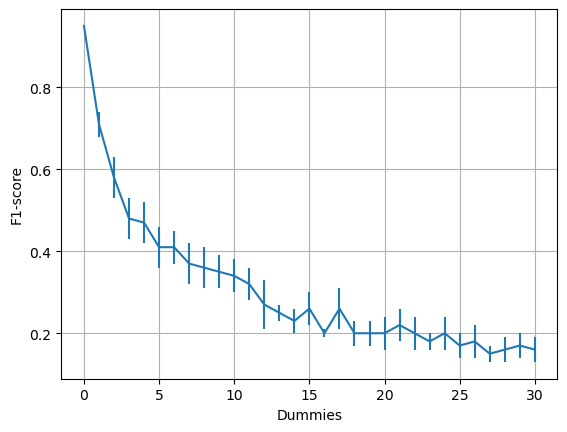

In [16]:
clf_res_dummies = np.load('datasets/clf_res_dummies.npy', allow_pickle=True).item()

plot_data = []

for howmany in clf_res_dummies:
    clf_res, cost = clf_res_dummies[howmany]
    med_bw, mean_bw, added_time, added_req = cost

    f1 = round(clf_res['score']['f1score'][0], 2)
    f1std = round(clf_res['score']['f1score'][1], 2)

    plot_data.append([int(howmany), f1, f1std, round(med_bw, 2), round(added_req, 2)])

print(plot_data)

xs = [row[0] for row in plot_data]
ys = [row[1] for row in plot_data]
yserr = [row[2] for row in plot_data]
medbw = [row[3] for row in plot_data]


plt.errorbar(xs, ys, yerr=yserr)
plt.xlabel("Dummies")
plt.ylabel("F1-score")
plt.grid()

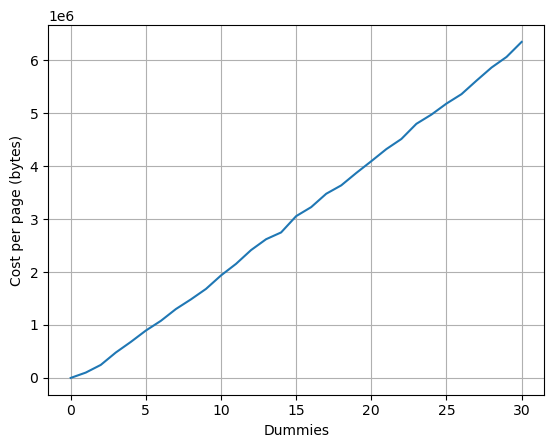

In [18]:
plt.plot(xs, medbw)
plt.xlabel("Dummies")
plt.ylabel("Cost per page (bytes)")
plt.grid()